<a href="https://colab.research.google.com/github/bringol/IA_TP_GRUPO_2/blob/dev/Dataset_no_me_comas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset: Yellow Submarine
----

Cada fila representa un hongo, cada columna contiene atributos de este.

La columna *classes* indica si el hongo es venenoso o no.

hongos | atributos
:----:   | :----:
8124     | 23


# Variables

Nombre   |  Posibles valores
:------- |  :---
cap-shape   | (bell, conical, convex, flat, knobbed, sunken)
cap-surface | (fibrous, grooves, scaly, smooth)
cap-color | (brown, buff, cinnamon, gray, green, pink, purple, red, white, yellow)
bruises | (bruises, no)
odor | (almond, anise, creosote, fishy, foul, musty, none, pungent, spicy)
gill-attachment | (attached, descending, free, notched)
gill-spacing | (close, crowded, distant)
gill-size | (broad, narrow)
gill-color | (black, brown, buff, chocolate, gray, green, orange, pink, purple, red, white, yellow)
stalk-shape | (enlarging, tapering)
stalk-root | (bulbous, club, cup, equal, rhizomorphs, rooted, missing)
stalk-surface-above-ring | (fibrous, scaly, silky, smooth)
stalk-surface-below-ring | (fibrous, scaly, silky, smooth)
stalk-color-above-ring | (brown, buff, cinnamon, gray, orange, pink, red, white, yellow)
stalk-color-below-ring | (brown, buff, cinnamon, gray, orange, pink, red, white, yellow)
veil-type | (partial, universal)
veil-color | (brown, orange, white, yellow)
ring-number | (none, one, two)
ring-type | (cobwebby, evanescent, flaring, large, none, pendant, sheathing, zone)
spore-print-color | (black, brown, buff, chocolate, green, orange, purple, white, yellow)
population | (abundant, clustered, numerous, scattered ,several, solitary)
habitat | (grasses, leaves, meadows, paths, urban, waste, woods)
classes   |  (edible, poisonous)

In [18]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.7 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import seaborn as sns
import optuna


# Cargar los datos
mushroom_data = pd.read_csv('Yellow_Submarine.csv')

In [20]:
# Verificar valores faltantes
missing_values = mushroom_data.isnull().sum()
print("Valores faltantes en cada columna:")
print(missing_values)

Valores faltantes en cada columna:
class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


In [21]:
# Convertir todas las categorías a minúsculas
for col in mushroom_data.select_dtypes(include=['object']).columns:
    mushroom_data[col] = mushroom_data[col].str.lower()

In [22]:
# Verificar la distribución de valores en la columna "veil-type"
#veil_type_distribution = mushroom_data['veil-type'].value_counts()
#print(veil_type_distribution)

# Remover la columna 'veil-type' y 'stalk-shape'
mushroom_data.drop(columns=['veil-type','stalk-shape'], inplace=True)

In [23]:
# Cheqeuar la distribución de clases
class_distribution = mushroom_data['class'].value_counts()
print(class_distribution)

class
edible     4208
poisson    3916
Name: count, dtype: int64


#Cambiar "poisson" por "poisonous"

In [24]:
# Original
print(mushroom_data['class'].value_counts())

# Cambiar el nombre 'poisson' a 'poisonous' en la columna 'class'
mushroom_data['class'] = mushroom_data['class'].replace({'poisson': 'poisonous'})

# Verificar que el cambio se haya realizado
print(mushroom_data['class'].value_counts())

class
edible     4208
poisson    3916
Name: count, dtype: int64
class
edible       4208
poisonous    3916
Name: count, dtype: int64


In [25]:
# Lista de columnas a verificar
columns_to_check = [
    'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population',
    'habitat'
]

# Verificar la distribución de "edible" y "poisonous" para cada categoría en cada columna
for column in columns_to_check:
    print(f"Distribución de 'class' para cada valor en '{column}':")
    distribution = mushroom_data.groupby([column, 'class']).size().unstack(fill_value=0)
    print(distribution)
    print("\n")

Distribución de 'class' para cada valor en 'cap-shape':
class      edible  poisonous
cap-shape                   
bell          404         48
conical         0          4
convex       1948       1708
flat         1596       1556
knobbed       228        600
sunken         32          0


Distribución de 'class' para cada valor en 'cap-surface':
class        edible  poisonous
cap-surface                   
fibrous        1560        760
grooves           0          4
scaly          1504       1740
smooth         1144       1412


Distribución de 'class' para cada valor en 'cap-color':
class      edible  poisonous
cap-color                   
brown        1264       1020
buff           48        120
cinnamon       32         12
gray         1032        808
green          16          0
pink           56         88
purple         16          0
red           624        876
white         720        320
yellow        400        672


Distribución de 'class' para cada valor en 'bruises':
clas

#Borrar datos que no aportan valor
cap-shape->
    convex;flat

cap-surface->
    scaly;smooth

cap-color->
    brown;red;yellow

gill-attachment->
    free

gill-color->
    chocolate;gray;pink

gill-attachment->
    close

stalk-root->
    bulbous

stalk-color-below-ring->
    white

veil-color->
    white

ring-number->
    one

ring-type->
    evanescent

habitat->
    woods



In [26]:
# Reemplazar los valores especificados con NaN
values_to_replace = {
    'cap-shape': ['convex', 'flat'],
    'cap-surface': ['scaly', 'smooth'],
    'cap-color': ['brown', 'red', 'yellow'],
    'gill-attachment': ['free'],
    'gill-color': ['chocolate', 'gray', 'pink'],
    'gill-spacing': ['close'],
    'stalk-root': ['bulbous'],
    'stalk-color-below-ring': ['white'],
    'veil-color': ['white'],
    'ring-number': ['one'],
    'ring-type': ['evanescent'],
    'habitat': ['woods']
}

for column, values in values_to_replace.items():
    mushroom_data[column] = mushroom_data[column].replace(values, np.nan)

# Verificar el resultado
print(mushroom_data.head())

# Verificar el número de valores nulos
missing_values = mushroom_data.isnull().sum()
print("Valores faltantes en cada columna después de la sustitución:")
print(missing_values)

       class cap-shape cap-surface cap-color  bruises     odor  \
0  poisonous       NaN         NaN       NaN  bruises  pungent   
1     edible       NaN         NaN       NaN  bruises   almond   
2     edible      bell         NaN     white  bruises    anise   
3  poisonous       NaN         NaN     white  bruises  pungent   
4     edible       NaN         NaN      gray       no     none   

  gill-attachment gill-spacing gill-size gill-color  ...  \
0             NaN          NaN    narrow      black  ...   
1             NaN          NaN     broad      black  ...   
2             NaN          NaN     broad      brown  ...   
3             NaN          NaN    narrow      brown  ...   
4             NaN      crowded     broad      black  ...   

  stalk-surface-above-ring stalk-surface-below-ring stalk-color-above-ring  \
0                   smooth                   smooth                  white   
1                   smooth                   smooth                  white   
2       

#Gráfico de Barras

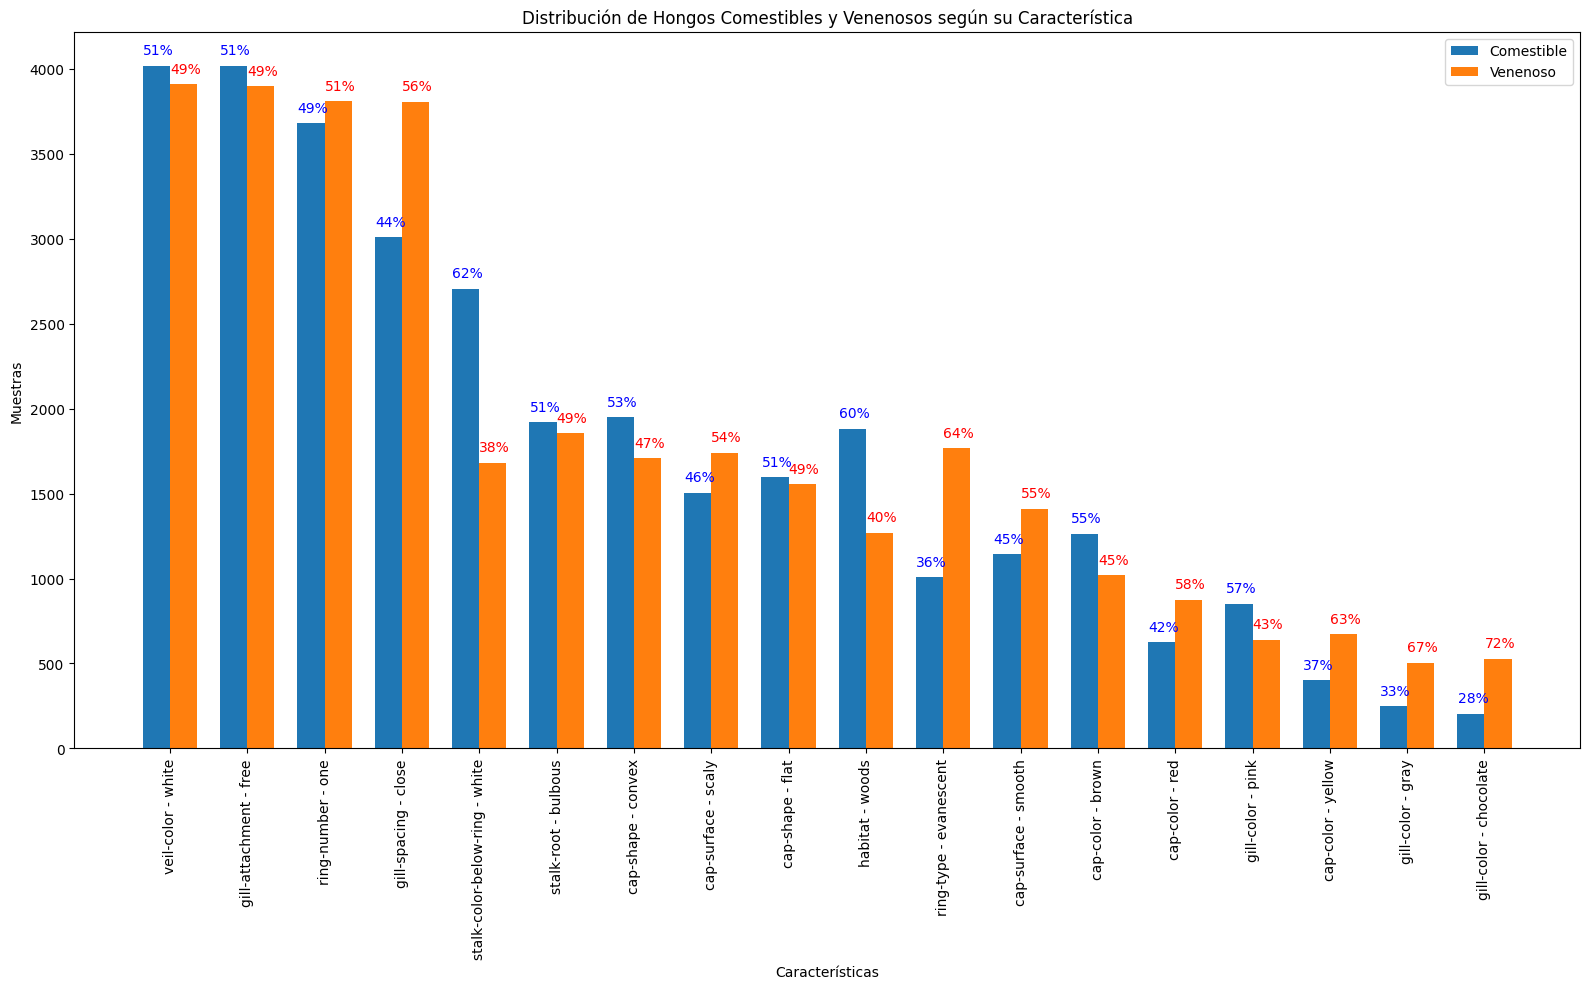

<Figure size 640x480 with 0 Axes>

In [17]:
# Datos proporcionados
data_ambiguas = {
    'Feature': ['cap-shape', 'cap-shape', 'cap-surface', 'cap-surface', 'cap-color', 'cap-color', 'cap-color', 'gill-attachment', 'gill-color', 'gill-color', 'gill-color', 'gill-spacing', 'stalk-root', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'habitat'],
    'Value': ['convex', 'flat', 'scaly', 'smooth', 'brown', 'red', 'yellow', 'free', 'chocolate', 'gray', 'pink', 'close', 'bulbous', 'white', 'white', 'one', 'evanescent', 'woods'],
    'Edible': [1948, 1596, 1504, 1144, 1264, 624, 400, 4016, 204, 248, 852, 3008, 1920, 2704, 4016, 3680, 1008, 1880],
    'Poisonous': [1708, 1556, 1740, 1412, 1020, 876, 672, 3898, 528, 504, 640, 3804, 1856, 1680, 3908, 3808, 1768, 1268]
}

df_ambiguas = pd.DataFrame(data_ambiguas)

# Ordenar los datos
df_ambiguas['Total'] = df_ambiguas['Edible'] + df_ambiguas['Poisonous']
df_ambiguas = df_ambiguas.sort_values(by='Total', ascending=False)

# Graficar los datos
fig, ax = plt.subplots(figsize=(16, 10))
bar_width = 0.35
index = np.arange(len(df_ambiguas))

bar1 = ax.bar(index, df_ambiguas['Edible'], bar_width, label='Comestible')
bar2 = ax.bar(index + bar_width, df_ambiguas['Poisonous'], bar_width, label='Venenoso')

ax.set_xlabel('Características')
ax.set_ylabel('Muestras')
ax.set_title('Distribución de Hongos Comestibles y Venenosos según su Característica')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_ambiguas['Feature'] + " - " + df_ambiguas['Value'], rotation=90)
ax.legend()

# Agregar porcentajes sobre las barras
for i in range(len(df_ambiguas)):
    total = df_ambiguas['Total'].iloc[i]
    edible = df_ambiguas['Edible'].iloc[i]
    poisonous = df_ambiguas['Poisonous'].iloc[i]
    edible_pct = (edible / total) * 100
    poisonous_pct = (poisonous / total) * 100

    ax.text(index[i] - bar_width / 2 + 0.2, edible + 50, f'{edible_pct:.0f}%', ha='center', va='bottom', fontsize=10, color='blue')
    ax.text(index[i] + bar_width / 2 + 0.2, poisonous + 50, f'{poisonous_pct:.0f}%', ha='center', va='bottom', fontsize=10, color='red')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()




#Chequeo de resultados

In [27]:
# Lista de columnas a verificar
columns_to_check = [
    'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population',
    'habitat'
]

# Verificar la distribución de "edible" y "poisonous" para cada categoría en cada columna
for column in columns_to_check:
    print(f"Distribución de 'class' para cada valor en '{column}':")
    distribution = mushroom_data.groupby([column, 'class']).size().unstack(fill_value=0)
    print(distribution)
    print("\n")

# Cheqeuar la distribución de clases
class_distribution = mushroom_data['class'].value_counts()
print(class_distribution)

Distribución de 'class' para cada valor en 'cap-shape':
class      edible  poisonous
cap-shape                   
bell          404         48
conical         0          4
knobbed       228        600
sunken         32          0


Distribución de 'class' para cada valor en 'cap-surface':
class        edible  poisonous
cap-surface                   
fibrous        1560        760
grooves           0          4


Distribución de 'class' para cada valor en 'cap-color':
class      edible  poisonous
cap-color                   
buff           48        120
cinnamon       32         12
gray         1032        808
green          16          0
pink           56         88
purple         16          0
white         720        320


Distribución de 'class' para cada valor en 'bruises':
class    edible  poisonous
bruises                   
bruises    2752        624
no         1456       3292


Distribución de 'class' para cada valor en 'odor':
class     edible  poisonous
odor                  

#Consolidar columnas agrupando categorías en "other"

1.   Función para Consolidar Categorías Escasas: La función consolidate_categories agrupa categorías con baja frecuencia en "other".
2.   Aplicar la Consolidación: Se aplica la consolidación a las columnas especificadas.
3.   Verificar la Distribución Después de la Consolidación: Se imprime la distribución de valores en cada columna especificada después de la consolidación, agrupada por la clase (class).
4.   Resultado Esperado
El resultado mostrará la distribución de edible y poisonous para cada valor en las columnas especificadas, después de que las categorías escasas se hayan consolidado en "other".




In [5]:
# Función para consolidar categorías escasas
def consolidate_categories(df, column, min_count=50):
    value_counts = df[column].value_counts()
    to_consolidate = value_counts[value_counts < min_count].index
    df[column] = df[column].apply(lambda x: 'other' if x in to_consolidate else x)
    return df

# Especificar las columnas a consolidar
columns_to_consolidate = [
    'cap-shape', 'cap-color', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'ring-type', 'spore-print-color'
]

# Aplicar la consolidación a las columnas específicas
for column in columns_to_consolidate:
    mushroom_data = consolidate_categories(mushroom_data, column, min_count=50)

# Verificar la distribución después de la consolidación
for column in mushroom_data.columns:
    if column != 'class':
        print(f"Distribución de 'class' para cada valor en '{column}':")
        distribution = mushroom_data.groupby([column, 'class']).size().unstack(fill_value=0)
        print(distribution)
        print("\n")

Distribución de 'class' para cada valor en 'cap-shape':
class      edible  poisonous
cap-shape                   
bell          404         48
convex       1948       1708
flat         1596       1556
knobbed       228        600
other          32          4


Distribución de 'class' para cada valor en 'cap-surface':
class        edible  poisonous
cap-surface                   
fibrous        1560        760
grooves           0          4
scaly          1504       1740
smooth         1144       1412


Distribución de 'class' para cada valor en 'cap-color':
class      edible  poisonous
cap-color                   
brown        1264       1020
buff           48        120
gray         1032        808
other          64         12
pink           56         88
red           624        876
white         720        320
yellow        400        672


Distribución de 'class' para cada valor en 'bruises':
class    edible  poisonous
bruises                   
bruises    2752        624
no        

#Verificar Fuga de Datos

#One-Hot-Encoding

In [25]:
# Aplicar One-Hot Encoding
mushroom_data_encoded = pd.get_dummies(mushroom_data, drop_first=True)

# Verificar el resultado
print(mushroom_data_encoded.head())

# Mostrar la cantidad de columnas después de One-Hot Encoding
print("Cantidad de columnas después de One-Hot Encoding:", mushroom_data_encoded.shape[1])

   class_poisonous  cap-shape_convex  cap-shape_flat  cap-shape_knobbed  \
0             True              True           False              False   
1            False              True           False              False   
2            False             False           False              False   
3             True              True           False              False   
4            False              True           False              False   

   cap-shape_other  cap-surface_grooves  cap-surface_scaly  \
0            False                False              False   
1            False                False              False   
2            False                False              False   
3            False                False               True   
4            False                False              False   

   cap-surface_smooth  cap-color_buff  cap-color_gray  ...  \
0                True           False           False  ...   
1                True           False           Fals

In [ ]:
# Revisar las correlaciones entre las características y la variable objetivo
corr_matrix = mushroom_data_encoded.corr()
print(corr_matrix['class_poisonous'].sort_values(ascending=False))


class_poisonous                    1.000000
odor_foul                          0.623842
stalk-surface-above-ring_silky     0.587658
stalk-surface-below-ring_silky     0.573524
gill-size_narrow                   0.540024
                                     ...   
spore-print-color_brown           -0.416645
stalk-surface-below-ring_smooth   -0.425444
stalk-surface-above-ring_smooth   -0.491314
ring-type_pendant                 -0.540469
odor_none                         -0.785557
Name: class_poisonous, Length: 87, dtype: float64


class_poisonous                    1.000000
odor_foul                          0.623842
stalk-surface-above-ring_silky     0.587658
stalk-surface-below-ring_silky     0.573524
gill-size_narrow                   0.540024
                                     ...   
spore-print-color_brown           -0.416645
stalk-surface-below-ring_smooth   -0.425444
stalk-surface-above-ring_smooth   -0.491314
ring-type_pendant                 -0.540469
odor_none                         -0.785557
Name: class_poisonous, Length: 87, dtype: float64


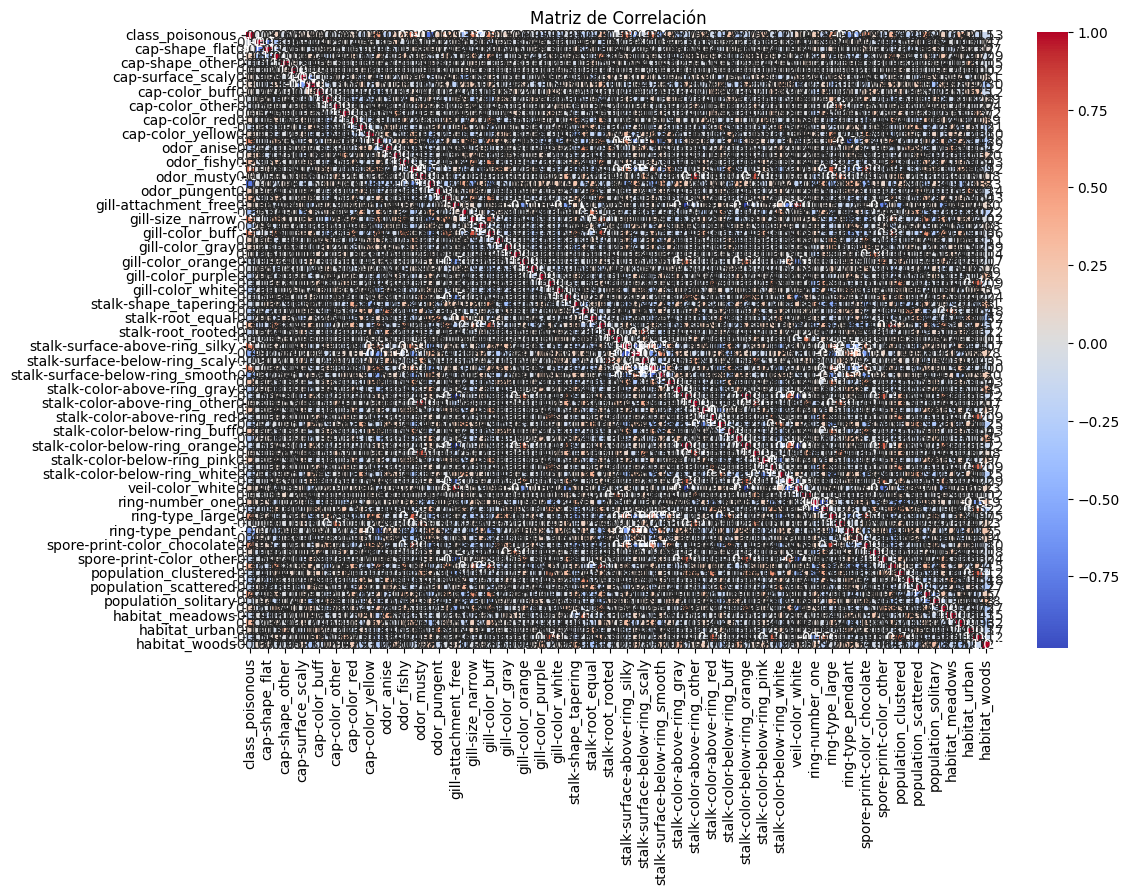

In [34]:
# Revisar las correlaciones entre las características y la variable objetivo
corr_matrix = mushroom_data_encoded.corr()
print(corr_matrix['class_poisonous'].sort_values(ascending=False))

# Visualizar las correlaciones más fuertes

#plt.figure(figsize=(12, 8))
#sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
#plt.title('Matriz de Correlación')
#plt.show()

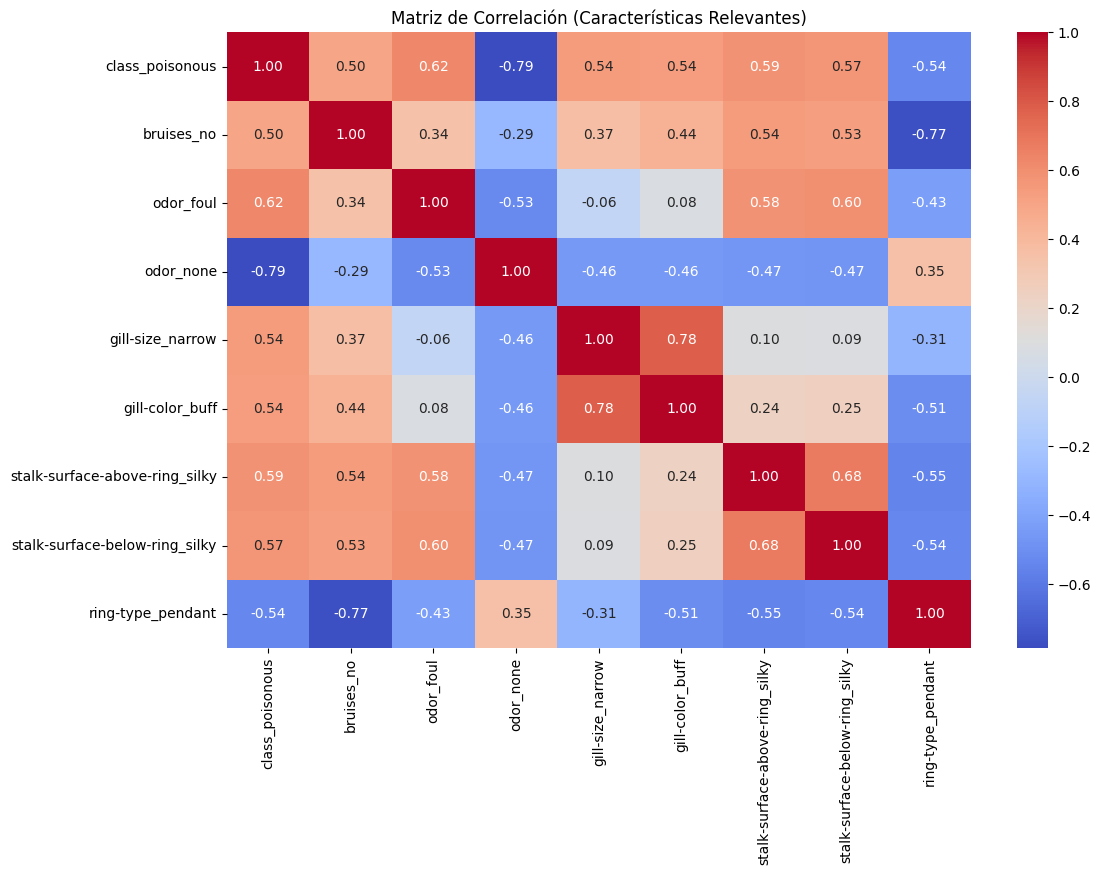

In [36]:
# Calcular la matriz de correlación
corr_matrix = mushroom_data_encoded.corr()

# Filtrar características con correlación absoluta mayor a 0.5 con la variable objetivo
corr_target = corr_matrix['class_poisonous'].abs()
relevant_features = corr_target[corr_target > 0.5].index

# Crear una nueva matriz de correlación solo con las características relevantes
filtered_corr_matrix = mushroom_data_encoded[relevant_features].corr()

# Graficar la nueva matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación (Características Relevantes)')
plt.show()


#Separación de Características

In [26]:
# Separar las características (X) y la variable objetivo (y)
X = mushroom_data_encoded.drop('class_poisonous', axis=1)
y = mushroom_data_encoded['class_poisonous']

#División de Datos

In [27]:
# Dividir los datos en conjuntos de entrenamiento y prueba antes de aplicar PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Escalado de Características

In [28]:
# Escalar las características solo en el conjunto de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Aplicación de PCA (Análisis de Componentes Principales)

Para reducir la dimensionalidad del dataset después de ralizar One-Hot-Encoding

In [29]:
# Aplicar PCA solo en el conjunto de entrenamiento
pca = PCA(n_components=0.95)  # Retener el 95% de la variación
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Verificar la nueva forma de los datos después de PCA
print(f"Forma original de X: {X.shape}")
print(f"Forma de X después de PCA: {X_train_pca.shape}")


'''
# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=0.95)  # Retener el 95% de la variación
X_pca = pca.fit_transform(X_scaled)

# Verificar la nueva forma de los datos después de PCA
print(f"Forma original de X: {X.shape}")
print(f"Forma de X después de PCA: {X_pca.shape}")

# Imprimir la cantidad de varianza explicada por cada componente principal
print(f"Varianza explicada por cada componente principal: {pca.explained_variance_ratio_}")
print(f"Varianza explicada acumulada: {pca.explained_variance_ratio_.cumsum()}")
'''


Forma original de X: (8124, 86)
Forma de X después de PCA: (6499, 50)


'\n# Escalar las características\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# Aplicar PCA\npca = PCA(n_components=0.95)  # Retener el 95% de la variación\nX_pca = pca.fit_transform(X_scaled)\n\n# Verificar la nueva forma de los datos después de PCA\nprint(f"Forma original de X: {X.shape}")\nprint(f"Forma de X después de PCA: {X_pca.shape}")\n\n# Imprimir la cantidad de varianza explicada por cada componente principal\nprint(f"Varianza explicada por cada componente principal: {pca.explained_variance_ratio_}")\nprint(f"Varianza explicada acumulada: {pca.explained_variance_ratio_.cumsum()}")\n'

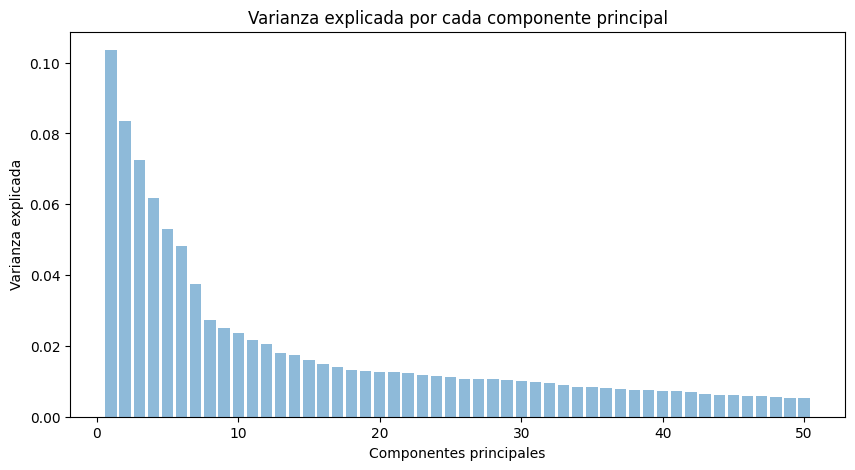

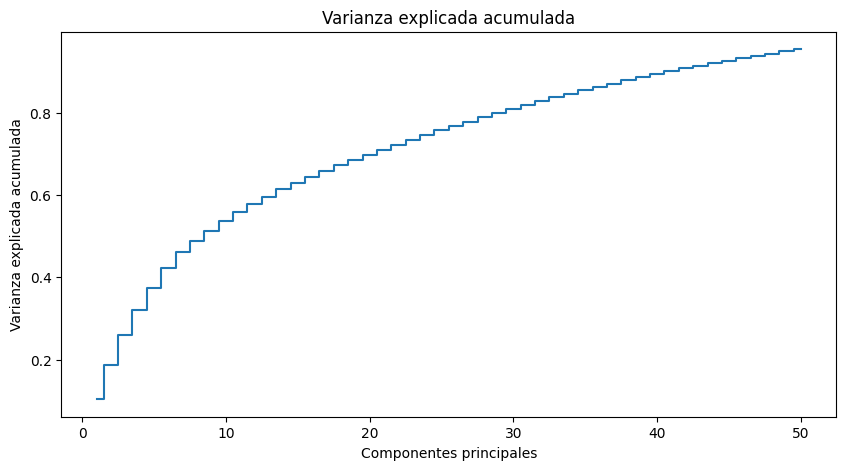

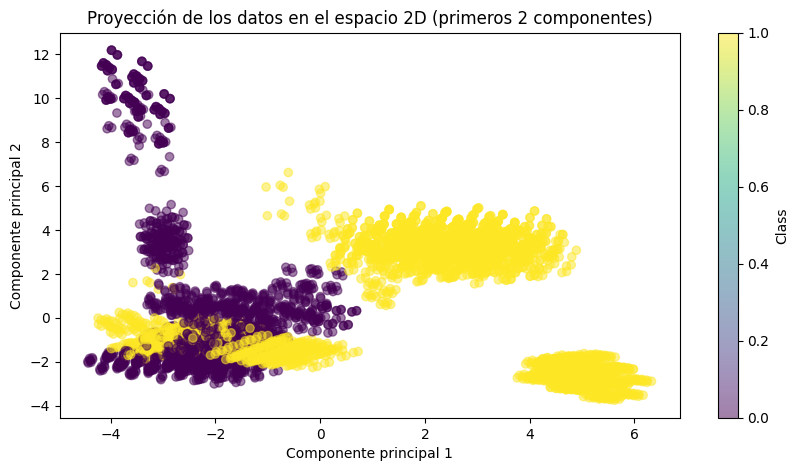

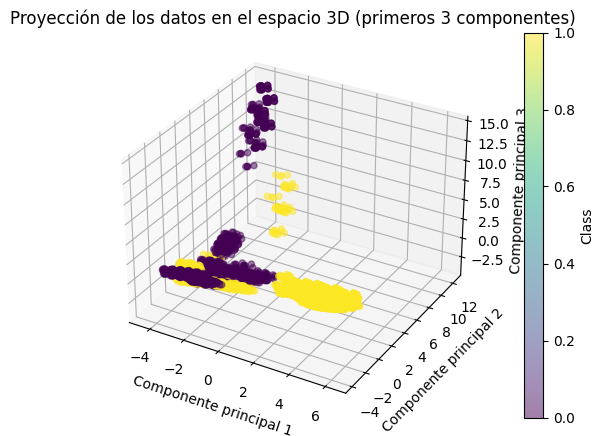

In [ ]:
# Gráfico de varianza explicada por cada componente principal
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada')
plt.title('Varianza explicada por cada componente principal')
plt.show()

# Gráfico de varianza explicada acumulada
plt.figure(figsize=(10, 5))
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), where='mid')
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada')
plt.show()

# Gráfico de proyección en el espacio 2D
plt.figure(figsize=(10, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Proyección de los datos en el espacio 2D (primeros 2 componentes)')
plt.colorbar(label='Class')
plt.show()

# Gráfico en 3D (requiere mpl_toolkits.mplot3d)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.5)
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
ax.set_title('Proyección de los datos en el espacio 3D (primeros 3 componentes)')
fig.colorbar(scatter, ax=ax, label='Class')
plt.show()

#Optimización Random Forest

In [ ]:
# Crear un pipeline que incluye el escalado de características y la aplicación de PCA
def create_pipeline(max_depth, min_samples_split, n_estimators):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('clf', RandomForestClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            n_estimators=n_estimators,
            random_state=42))
    ])

# Función de objetivo para optimización bayesiana
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 22)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 200)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)

    pipeline = create_pipeline(max_depth, min_samples_split, n_estimators)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    return scores.mean()

# Crear un estudio y optimizar los hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros encontrados por Optuna:")
print(study.best_params)
print(f"Mejor score de validación: {study.best_value:.4f}")

# Visualizar la importancia de los hiperparámetros
optuna.visualization.plot_param_importances(study)
plt.show()

# Visualizar la historia de optimización
optuna.visualization.plot_optimization_history(study)
plt.show()

#Optimización SVM

In [ ]:
# Crear un pipeline que incluye el escalado de características y la aplicación de PCA
def create_pipeline_svm(C, kernel, gamma):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('clf', SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
    ])

# Función de objetivo para optimización bayesiana
def objective_svm(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e1)

    pipeline = create_pipeline_svm(C, kernel, gamma)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    return scores.mean()

# Crear un estudio y optimizar los hiperparámetros
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=50)

# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros encontrados por Optuna para SVM:")
print(study_svm.best_params)
print(f"Mejor score de validación para SVM: {study_svm.best_value:.4f}")

# Visualizar la importancia de los hiperparámetros
optuna.visualization.plot_param_importances(study_svm)
plt.title("Importancia de los Hiperparámetros (SVM)")
plt.show()

# Visualizar la historia de optimización
optuna.visualization.plot_optimization_history(study_svm)
plt.title("Historia de Optimización (SVM)")
plt.show()


#Optimización KNN

In [ ]:
# Crear un pipeline que incluye el escalado de características y la aplicación de PCA
def create_pipeline_knn(n_neighbors, p):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('clf', KNeighborsClassifier(n_neighbors=n_neighbors, p=p))
    ])

# Función de objetivo para optimización bayesiana
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    p = trial.suggest_int('p', 1, 2)

    pipeline = create_pipeline_knn(n_neighbors, p)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    return scores.mean()

# Crear un estudio y optimizar los hiperparámetros
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=50)

# Imprimir los mejores parámetros y el mejor score
print("Mejores parámetros encontrados por Optuna para KNN:")
print(study_knn.best_params)
print(f"Mejor score de validación para KNN: {study_knn.best_value:.4f}")

# Visualizar la importancia de los hiperparámetros
optuna.visualization.plot_param_importances(study_knn)
plt.title("Importancia de los Hiperparámetros (KNN)")
plt.show()

# Visualizar la historia de optimización
optuna.visualization.plot_optimization_history(study_knn)
plt.title("Historia de Optimización (KNN)")
plt.show()


#Entrenamiento y Evaluación de Modelos

 División de Modelos

#Random Forest

In [30]:
# Definir los mejores parámetros encontrados por la optimización bayesiana para Random Forest
best_params_rf = {
    'max_depth': 14,
    'min_samples_split': 55,
    'n_estimators': 416
}

# Crear el modelo Random Forest con los mejores parámetros
rf_model = RandomForestClassifier(
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    n_estimators=best_params_rf['n_estimators']
)

# Entrenar el modelo Random Forest con tus datos de entrenamiento
#rf_model.fit(X_train, y_train)
rf_model.fit(X_train_pca, y_train)
# Hacer predicciones en los datos de prueba
y_pred_rf = rf_model.predict(X_test_pca)

# Calcular y mostrar las métricas
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
#recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f'Random Forest Precision: {precision_rf:.4f}')
print(f'Random Forest Recall: {recall_rf:.4f}')
print(f'Random Forest F1 Score: {f1_rf:.4f}')

Random Forest Precision: 1.0000
Random Forest Recall: 1.0000
Random Forest F1 Score: 1.0000


In [ ]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_pca, y_train)
y_pred_rf = rf_clf.predict(X_test_pca)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Exactitud de Random Forest: {accuracy_rf:.4f}")
print("Reporte de clasificación de Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Matriz de confusión de Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))


Exactitud de Random Forest: 1.0000
Reporte de clasificación de Random Forest:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       843
        True       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Matriz de confusión de Random Forest:
[[843   0]
 [  0 782]]


#SVM

In [ ]:
# Definir los mejores parámetros encontrados por la optimización bayesiana para SVM
best_params_svm = {
    'C': 72.4650505109439,
    'kernel': 'poly',
    'gamma': 0.038527595905536574
}

# Crear el modelo SVM con los mejores parámetros
svm_model = SVC(
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma']
)

# Entrenar el modelo SVM con tus datos de entrenamiento
svm_model.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba
y_pred_svm = svm_model.predict(X_test)

# Calcular y mostrar las métricas
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print(f'SVM Precision: {precision_svm:.4f}')
print(f'SVM Recall: {recall_svm:.4f}')
print(f'SVM F1 Score: {f1_svm:.4f}')


In [ ]:
# Support Vector Machine (SVM)
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_pca, y_train)
y_pred_svm = svm_clf.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Exactitud de SVM: {accuracy_svm:.4f}")
print("Reporte de clasificación de SVM:")
print(classification_report(y_test, y_pred_svm))
print("Matriz de confusión de SVM:")
print(confusion_matrix(y_test, y_pred_svm))

Exactitud de SVM: 1.0000
Reporte de clasificación de SVM:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       843
        True       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Matriz de confusión de SVM:
[[843   0]
 [  0 782]]


#KNN

In [17]:
# Definir los mejores parámetros encontrados por la optimización bayesiana para KNN
best_params_knn = {
    'n_neighbors': 1,
    'p': 2
}

# Crear el modelo KNN con los mejores parámetros
knn_model = KNeighborsClassifier(
    n_neighbors=best_params_knn['n_neighbors'],
    p=best_params_knn['p']
)

# Entrenar el modelo KNN con tus datos de entrenamiento
#knn_model.fit(X_train, y_train)
knn_model.fit(X_train_pca, y_train)

# Hacer predicciones en los datos de prueba
#y_pred_knn = knn_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test_pca)

# Calcular y mostrar las métricas
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f'KNN Precision: {precision_knn:.4f}')
print(f'KNN Recall: {recall_knn:.4f}')
print(f'KNN F1 Score: {f1_knn:.4f}')

KNN Precision: 1.0000
KNN Recall: 1.0000
KNN F1 Score: 1.0000


In [ ]:
# Implementar K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Exactitud de K-Nearest Neighbors: {accuracy_knn:.4f}")
print("Reporte de clasificación de K-Nearest Neighbors:")
print(classification_report(y_test, y_pred_knn))
print("Matriz de confusión de K-Nearest Neighbors:")
print(confusion_matrix(y_test, y_pred_knn))

Exactitud de K-Nearest Neighbors: 1.0000
Reporte de clasificación de K-Nearest Neighbors:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       843
        True       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Matriz de confusión de K-Nearest Neighbors:
[[843   0]
 [  0 782]]


#Validación cruzada estratificada


In [33]:
# Escalar las características y aplicar PCA dentro de un pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

X_pca = pipeline.fit_transform(X)

# Definir los modelos con los mejores hiperparámetros
models = {
    'Random Forest': RandomForestClassifier(max_depth=14, min_samples_split=55, n_estimators=416, random_state=42),
    'SVM': SVC(C=72.4650505109439, kernel='poly', gamma=0.038527595905536574, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=1, p=2)
}

# Definir la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir los scorers
scorers = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Realizar validación cruzada estratificada para cada modelo y cada métrica
for model_name, model in models.items():
    print(f"Validación cruzada para {model_name}")
    for metric_name, scorer in scorers.items():
        scores = cross_val_score(model, X_pca, y, cv=cv, scoring=scorer)
        print(f"{metric_name.capitalize()} Scores: {scores}")
        print(f"Promedio {metric_name.capitalize()}: {scores.mean():.4f}")
        print(f"Desviación estándar {metric_name.capitalize()}: {scores.std():.4f}")
    print("\n")

Validación cruzada para Random Forest
Precision Scores: [0.99938535 0.99938535 1.         0.99877215 0.99938497]
Promedio Precision: 0.9994
Desviación estándar Precision: 0.0004
Recall Scores: [0.99938462 0.99938462 1.         0.99876923 0.99938424]
Promedio Recall: 0.9994
Desviación estándar Recall: 0.0004
F1 Scores: [0.9993846  0.9993846  1.         0.99876917 0.99938422]
Promedio F1: 0.9994
Desviación estándar F1: 0.0004


Validación cruzada para SVM
Precision Scores: [1. 1. 1. 1. 1.]
Promedio Precision: 1.0000
Desviación estándar Precision: 0.0000
Recall Scores: [1. 1. 1. 1. 1.]
Promedio Recall: 1.0000
Desviación estándar Recall: 0.0000
F1 Scores: [1. 1. 1. 1. 1.]
Promedio F1: 1.0000
Desviación estándar F1: 0.0000


Validación cruzada para KNN
Precision Scores: [1.         0.99938535 1.         1.         1.        ]
Promedio Precision: 0.9999
Desviación estándar Precision: 0.0002
Recall Scores: [1.         0.99938462 1.         1.         1.        ]
Promedio Recall: 0.9999
Desvia

#Conjunto de prueba

In [ ]:
# Implementar K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Exactitud de K-Nearest Neighbors en conjunto de prueba: {accuracy_knn:.4f}")
print("Reporte de clasificación de K-Nearest Neighbors en conjunto de prueba:")
print(classification_report(y_test, y_pred_knn))
print("Matriz de confusión de K-Nearest Neighbors en conjunto de prueba:")
print(confusion_matrix(y_test, y_pred_knn))

Exactitud de K-Nearest Neighbors en conjunto de prueba: 1.0000
Reporte de clasificación de K-Nearest Neighbors en conjunto de prueba:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       843
        True       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Matriz de confusión de K-Nearest Neighbors en conjunto de prueba:
[[843   0]
 [  0 782]]


#Pruebas adicionales

In [ ]:
# Dividir los datos en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separar una porción del conjunto de prueba para un test adicional (50/50)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

# Aplicar PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test1_pca = pca.transform(X_test1_scaled)
X_test2_pca = pca.transform(X_test2_scaled)

# Entrenar y evaluar el modelo en el primer conjunto de prueba
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)
y_pred_test1 = knn.predict(X_test1_pca)
accuracy_test1 = accuracy_score(y_test1, y_pred_test1)
print(f"Exactitud de KNN en el primer conjunto de prueba: {accuracy_test1:.4f}")
print("Reporte de clasificación de KNN en el primer conjunto de prueba:")
print(classification_report(y_test1, y_pred_test1))
print("Matriz de confusión de KNN en el primer conjunto de prueba:")
print(confusion_matrix(y_test1, y_pred_test1))

# Evaluar el modelo en el segundo conjunto de prueba adicional
y_pred_test2 = knn.predict(X_test2_pca)
accuracy_test2 = accuracy_score(y_test2, y_pred_test2)
print(f"Exactitud de KNN en el segundo conjunto de prueba adicional: {accuracy_test2:.4f}")
print("Reporte de clasificación de KNN en el segundo conjunto de prueba adicional:")
print(classification_report(y_test2, y_pred_test2))
print("Matriz de confusión de KNN en el segundo conjunto de prueba adicional:")
print(confusion_matrix(y_test2, y_pred_test2))


Exactitud de KNN en el primer conjunto de prueba: 1.0000
Reporte de clasificación de KNN en el primer conjunto de prueba:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       413
        True       1.00      1.00      1.00       399

    accuracy                           1.00       812
   macro avg       1.00      1.00      1.00       812
weighted avg       1.00      1.00      1.00       812

Matriz de confusión de KNN en el primer conjunto de prueba:
[[413   0]
 [  0 399]]
Exactitud de KNN en el segundo conjunto de prueba adicional: 1.0000
Reporte de clasificación de KNN en el segundo conjunto de prueba adicional:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       430
        True       1.00      1.00      1.00       383

    accuracy                           1.00       813
   macro avg       1.00      1.00      1.00       813
weighted avg       1.00      1.00      1.00       81

#Verificación de Distribución de Clases

In [ ]:
# Verificar la distribución de clases en los conjuntos de entrenamiento y prueba
print("Distribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())

print("Distribución de clases en el primer conjunto de prueba:")
print(y_test1.value_counts())

print("Distribución de clases en el segundo conjunto de prueba adicional:")
print(y_test2.value_counts())


Distribución de clases en el conjunto de entrenamiento:
class_poisonous
False    3365
True     3134
Name: count, dtype: int64
Distribución de clases en el primer conjunto de prueba:
class_poisonous
False    413
True     399
Name: count, dtype: int64
Distribución de clases en el segundo conjunto de prueba adicional:
class_poisonous
False    430
True     383
Name: count, dtype: int64


#-------------------------------------------------------------

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Cargar los datos
mushroom_data = pd.read_csv('Yellow_Submarine.csv')

# Separar características y etiqueta
X = mushroom_data.drop('class', axis=1)
y = mushroom_data['class']

# Aplicar Label Encoding a todas las características categóricas
label_encoders = {}
for column in X.columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Aplicar Label Encoding a la variable objetivo
y_le = LabelEncoder()
y = y_le.fit_transform(y)

# Crear un pipeline para escalar y aplicar PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

# Transformar las características usando el pipeline
X_pca = pipeline.fit_transform(X)

# Definir los modelos a evaluar con los hiperparámetros optimizados
models = {
    'Random Forest': RandomForestClassifier(max_depth=14, min_samples_split=55, n_estimators=416, random_state=42),
    'SVM': SVC(C=72.465, kernel='poly', gamma=0.0385, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=1, p=2)
}

# Realizar validación cruzada estratificada para cada modelo
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Función para calcular métricas
def calculate_metrics(model, X, y, cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision', pos_label=1)
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall', pos_label=1)
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1', pos_label=1)
    return scores, precision, recall, f1

# Evaluar y mostrar resultados
for model_name, model in models.items():
    scores, precision, recall, f1 = calculate_metrics(model, X_pca, y, cv)
    print(f"Validación cruzada para {model_name}")
    print(f"Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"Precisión: {precision.mean():.4f} ± {precision.std():.4f}")
    print(f"Sensitividad: {recall.mean():.4f} ± {recall.std():.4f}")
    print(f"F1 Score: {f1.mean():.4f} ± {f1.std():.4f}")
    print("\n")


TypeError: cross_val_score() got an unexpected keyword argument 'pos_label'

In [ ]:
from sklearn.model_selection import cross_val_score

# Definir el modelo de Random Forest
rf_clf = RandomForestClassifier(random_state=42)

# Realizar validación cruzada
scores = cross_val_score(rf_clf, X_pca, y, cv=5)

# Imprimir los resultados de la validación cruzada
print(f"Scores de validación cruzada: {scores}")
print(f"Promedio de validación cruzada: {scores.mean():.4f}")
print(f"Desviación estándar de validación cruzada: {scores.std():.4f}")


Scores de validación cruzada: [0.83938462 1.         0.99138462 1.         0.70135468]
Promedio de validación cruzada: 0.9064
Desviación estándar de validación cruzada: 0.1194


In [ ]:
# Análisis de la importancia de características usando Random Forest
rf_clf.fit(X, y)
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Imprimir las características más importantes
print("Características más importantes:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")


Características más importantes:
1. odor_none (0.1281)
2. odor_foul (0.1045)
3. gill-size_narrow (0.0920)
4. stalk-surface-above-ring_silky (0.0524)
5. stalk-surface-below-ring_silky (0.0517)
6. gill-color_buff (0.0448)
7. stalk-surface-above-ring_smooth (0.0373)
8. bruises_no (0.0371)
9. ring-type_pendant (0.0344)
10. spore-print-color_chocolate (0.0339)
11. population_several (0.0267)
12. odor_pungent (0.0235)
13. gill-spacing_crowded (0.0224)
14. spore-print-color_white (0.0204)
15. ring-type_large (0.0191)
16. stalk-root_club (0.0183)
17. stalk-shape_tapering (0.0173)
18. spore-print-color_brown (0.0151)
19. odor_creosote (0.0140)
20. stalk-root_equal (0.0130)
21. odor_fishy (0.0110)
22. stalk-color-above-ring_white (0.0103)
23. odor_spicy (0.0102)
24. stalk-surface-below-ring_smooth (0.0100)
25. habitat_woods (0.0097)
26. spore-print-color_green (0.0089)
27. odor_anise (0.0079)
28. cap-color_yellow (0.0076)
29. habitat_urban (0.0072)
30. ring-number_one (0.0069)
31. stalk-root_mis

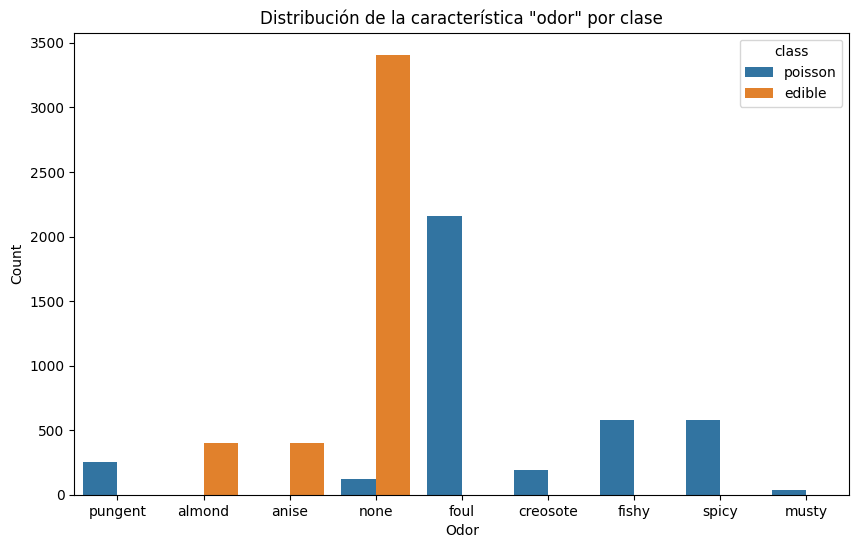

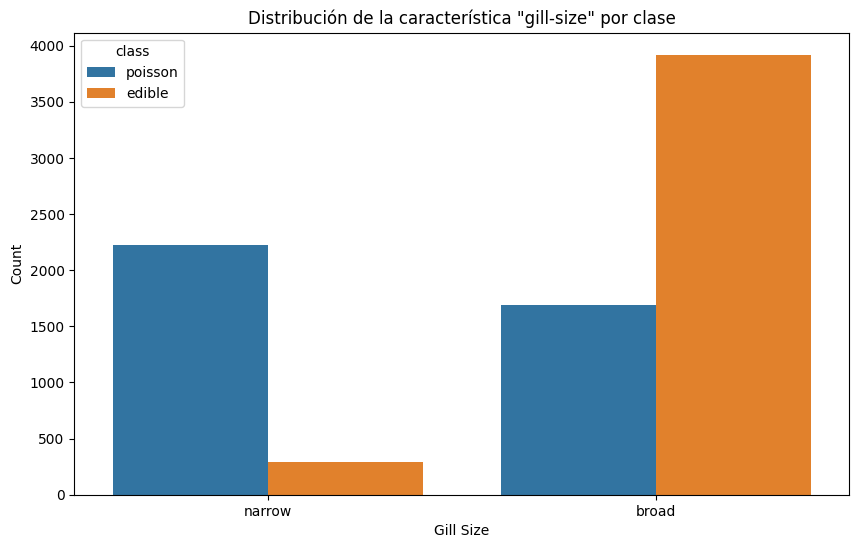

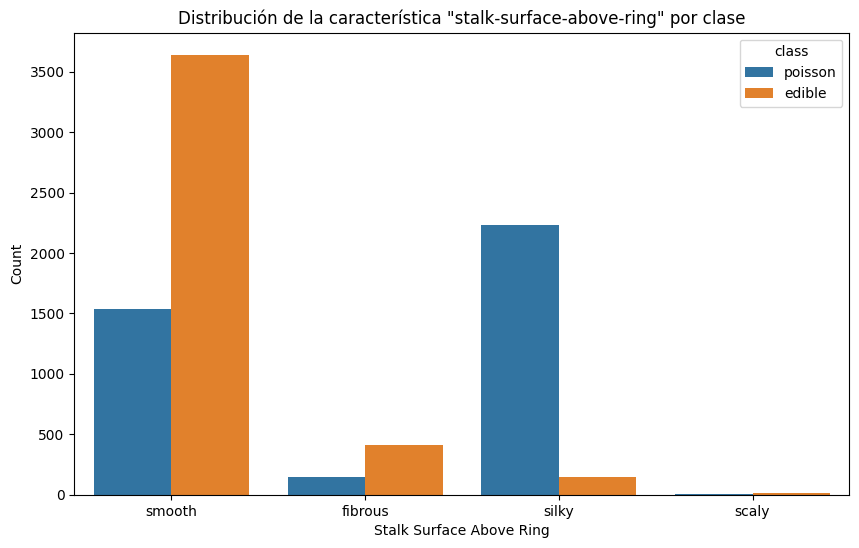

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exploración de la característica 'odor'
plt.figure(figsize=(10, 6))
sns.countplot(x='odor', hue='class', data=mushroom_data)
plt.title('Distribución de la característica "odor" por clase')
plt.xlabel('Odor')
plt.ylabel('Count')
plt.show()

# Exploración de la característica 'gill-size'
plt.figure(figsize=(10, 6))
sns.countplot(x='gill-size', hue='class', data=mushroom_data)
plt.title('Distribución de la característica "gill-size" por clase')
plt.xlabel('Gill Size')
plt.ylabel('Count')
plt.show()

# Exploración de la característica 'stalk-surface-above-ring'
plt.figure(figsize=(10, 6))
sns.countplot(x='stalk-surface-above-ring', hue='class', data=mushroom_data)
plt.title('Distribución de la característica "stalk-surface-above-ring" por clase')
plt.xlabel('Stalk Surface Above Ring')
plt.ylabel('Count')
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Definir el modelo de Random Forest
rf_clf = RandomForestClassifier(random_state=42)

# Realizar validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_clf, X_pca, y, cv=skf)

# Imprimir los resultados de la validación cruzada
print(f"Scores de validación cruzada: {scores}")
print(f"Promedio de validación cruzada: {scores.mean():.4f}")
print(f"Desviación estándar de validación cruzada: {scores.std():.4f}")


Scores de validación cruzada: [1.         0.99938462 1.         0.99876923 0.99938424]
Promedio de validación cruzada: 0.9995
Desviación estándar de validación cruzada: 0.0005


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Implementar K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Exactitud de K-Nearest Neighbors: {accuracy_knn:.4f}")
print("Reporte de clasificación de K-Nearest Neighbors:")
print(classification_report(y_test, y_pred_knn))
print("Matriz de confusión de K-Nearest Neighbors:")
print(confusion_matrix(y_test, y_pred_knn))

# Implementar Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_pca, y_train)
y_pred_gb = gb_clf.predict(X_test_pca)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Exactitud de Gradient Boosting: {accuracy_gb:.4f}")
print("Reporte de clasificación de Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))
print("Matriz de confusión de Gradient Boosting:")
print(confusion_matrix(y_test, y_pred_gb))

# Implementar Naive Bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train_pca, y_train)
y_pred_nb = nb_clf.predict(X_test_pca)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Exactitud de Naive Bayes: {accuracy_nb:.4f}")
print("Reporte de clasificación de Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
print("Matriz de confusión de Naive Bayes:")
print(confusion_matrix(y_test, y_pred_nb))

# Validación cruzada estratificada para los nuevos algoritmos

# K-Nearest Neighbors
scores_knn = cross_val_score(knn, X_pca, y, cv=skf)
print(f"Scores de validación cruzada de KNN: {scores_knn}")
print(f"Promedio de validación cruzada de KNN: {scores_knn.mean():.4f}")
print(f"Desviación estándar de validación cruzada de KNN: {scores_knn.std():.4f}")

# Gradient Boosting
scores_gb = cross_val_score(gb_clf, X_pca, y, cv=skf)
print(f"Scores de validación cruzada de Gradient Boosting: {scores_gb}")
print(f"Promedio de validación cruzada de Gradient Boosting: {scores_gb.mean():.4f}")
print(f"Desviación estándar de validación cruzada de Gradient Boosting: {scores_gb.std():.4f}")

# Naive Bayes
scores_nb = cross_val_score(nb_clf, X_pca, y, cv=skf)
print(f"Scores de validación cruzada de Naive Bayes: {scores_nb}")
print(f"Promedio de validación cruzada de Naive Bayes: {scores_nb.mean():.4f}")
print(f"Desviación estándar de validación cruzada de Naive Bayes: {scores_nb.std():.4f}")


Exactitud de K-Nearest Neighbors: 1.0000
Reporte de clasificación de K-Nearest Neighbors:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       843
        True       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Matriz de confusión de K-Nearest Neighbors:
[[843   0]
 [  0 782]]
Exactitud de Gradient Boosting: 0.9994
Reporte de clasificación de Gradient Boosting:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       843
        True       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Matriz de confusión de Gradient Boosting:
[[843   0]
 [  1 781]]
Exactitud de Naive Bayes: 0.9545
Repor

NameError: name 'skf' is not defined

In [17]:
# Separar las características (X) y la variable objetivo (y)
X = mushroom_data_encoded.drop('class_poisonous', axis=1)
y = mushroom_data_encoded['class_poisonous']

# Dividir los datos en conjuntos de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separar una porción del conjunto de prueba para un test adicional (50/50)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

# Aplicar PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test1_pca = pca.transform(X_test1_scaled)
X_test2_pca = pca.transform(X_test2_scaled)

# Verificar la nueva forma de los datos después de PCA
print(f"Forma original de X: {X.shape}")
print(f"Forma de X después de PCA: {X_train_pca.shape}")

# Verificar la distribución de clases en los conjuntos de entrenamiento y prueba
print("Distribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())

print("Distribución de clases en el primer conjunto de prueba:")
print(y_test1.value_counts())

print("Distribución de clases en el segundo conjunto de prueba adicional:")
print(y_test2.value_counts())

# Revisar las correlaciones entre las características y la variable objetivo
corr_matrix = mushroom_data_encoded.corr()
print(corr_matrix['class_poisonous'].sort_values(ascending=False))

# Entrenar y evaluar el modelo en el primer conjunto de prueba
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)
y_pred_test1 = knn.predict(X_test1_pca)
accuracy_test1 = accuracy_score(y_test1, y_pred_test1)
print(f"Exactitud de KNN en el primer conjunto de prueba: {accuracy_test1:.4f}")
print("Reporte de clasificación de KNN en el primer conjunto de prueba:")
print(classification_report(y_test1, y_pred_test1))
print("Matriz de confusión de KNN en el primer conjunto de prueba:")
print(confusion_matrix(y_test1, y_pred_test1))

# Evaluar el modelo en el segundo conjunto de prueba adicional
y_pred_test2 = knn.predict(X_test2_pca)
accuracy_test2 = accuracy_score(y_test2, y_pred_test2)
print(f"Exactitud de KNN en el segundo conjunto de prueba adicional: {accuracy_test2:.4f}")
print("Reporte de clasificación de KNN en el segundo conjunto de prueba adicional:")
print(classification_report(y_test2, y_pred_test2))
print("Matriz de confusión de KNN en el segundo conjunto de prueba adicional:")
print(confusion_matrix(y_test2, y_pred_test2))

Forma original de X: (8124, 86)
Forma de X después de PCA: (6499, 50)
Distribución de clases en el conjunto de entrenamiento:
class_poisonous
False    3365
True     3134
Name: count, dtype: int64
Distribución de clases en el primer conjunto de prueba:
class_poisonous
False    413
True     399
Name: count, dtype: int64
Distribución de clases en el segundo conjunto de prueba adicional:
class_poisonous
False    430
True     383
Name: count, dtype: int64
class_poisonous                    1.000000
odor_foul                          0.623842
stalk-surface-above-ring_silky     0.587658
stalk-surface-below-ring_silky     0.573524
gill-size_narrow                   0.540024
                                     ...   
spore-print-color_brown           -0.416645
stalk-surface-below-ring_smooth   -0.425444
stalk-surface-above-ring_smooth   -0.491314
ring-type_pendant                 -0.540469
odor_none                         -0.785557
Name: class_poisonous, Length: 87, dtype: float64
Exactitud d